In [50]:
from inda_mir.modeling.models import *
from inda_mir.modeling.evaluation import *
from inda_mir.loaders import load_data_partition
import pickle
import pandas as pd

In [51]:
threshold = 0.7

Insert the feature's csv here:

In [52]:
features_v2 = pd.read_csv('inda_mir_features_with_brass_v2.csv')
validation_features = pd.read_csv('validation_features.csv')
features_v1 = pd.read_csv('../output/features/our_extractor_features_with_brass.csv')

In [53]:
features_v2_unique = features_v2[~features_v2['track_id'].isin(features_v1['track_id'])]

In [54]:
len(features_v2_unique['track_id'].unique())

626

In [56]:
X_train_v2 = features_v2_unique.drop(
    ['filename', 'frame', 'track_id', 'label'], axis=1
)
y_train_v2 = features_v2_unique['label'].to_numpy()

In [57]:
X_train = features_v2.drop(
            ['filename', 'frame', 'track_id', 'label'], axis=1
        ).to_numpy()
y_train = features_v2['label'].to_numpy()

X_test = validation_features.drop(
            ['filename', 'frame', 'track_id', 'label'], axis=1
        ).to_numpy()
y_test = validation_features['label'].to_numpy()

In [58]:
print('Shapes:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print('------')
print('Values:')
print(f'X_train: {X_train}')
print(f'y_train: {y_train}')
print(f'X_test: {X_test}')
print(f'y_test: {y_test}')

Shapes:
X_train: (15541, 253)
y_train: (15541,)
X_test: (3744, 253)
y_test: (3744,)
------
Values:
X_train: [[2.21934548e-04 1.34907373e-06 4.78560787e-06 ... 1.92560365e-05
  5.02465487e-01 2.41863906e-01]
 [1.41979835e-03 6.81587107e-06 6.53895222e-06 ... 1.56729384e-05
  3.92998040e-01 3.33826423e-01]
 [3.57312616e-04 1.91261347e-06 6.57667533e-06 ... 1.92402840e-05
  4.86686379e-01 2.51972377e-01]
 ...
 [5.67162335e-01 1.98587213e-06 9.81687549e-07 ... 2.03240162e-07
  2.45562136e-01 2.12031566e-02]
 [3.41299176e-01 2.06450886e-06 8.92546154e-07 ... 2.85963864e-07
  2.79092699e-01 2.51479298e-02]
 [1.65186316e-01 1.71456304e-06 7.65856498e-07 ... 2.67064792e-07
  3.18047345e-01 2.56410260e-02]]
y_train: ['drums' 'drums' 'drums' ... 'vocals' 'vocals' 'vocals']
X_test: [[3.16167891e-01 1.84505586e-06 8.69993091e-05 ... 3.62962396e-06
  4.97534513e-01 3.64891514e-02]
 [4.97339427e-01 2.20402353e-06 8.78154751e-05 ... 3.43646821e-06
  4.48224843e-01 3.84615399e-02]
 [3.21612328e-01 2.2

## Model V1

In [59]:
model_v1 = 'models_lgbm_oe_rs_wbrass_27102023.pkl'
with open(model_v1, 'rb') as file:
    model_v1 = pickle.load(file)
model_v1.name = 'lgbm_v1'
predictions = model_v1.predict(X_test, threshold=threshold)

In [60]:
def get_confusion_matrix_tracklevel(model, predictions, y_test, features, threshold=0.7):
    aux_dataset = features[['track_id']].copy()
    aux_dataset['truth'] = y_test
    aux_dataset['prediction'] = predictions


    class_by_tracks = aux_dataset.groupby(['track_id']).agg({
        'truth': 'min',
        'prediction': lambda x: np.random.choice(x.mode(dropna=False))
    }).reset_index()

    labels = model.classes_
    cm = confusion_matrix(class_by_tracks['truth'].to_numpy(), class_by_tracks['prediction'].to_numpy(), labels=labels)[: len(labels) - 1]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(
        cm,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels[:-1],
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model.name}, Confidence: {threshold*100}%. Track level.')
    plt.show()


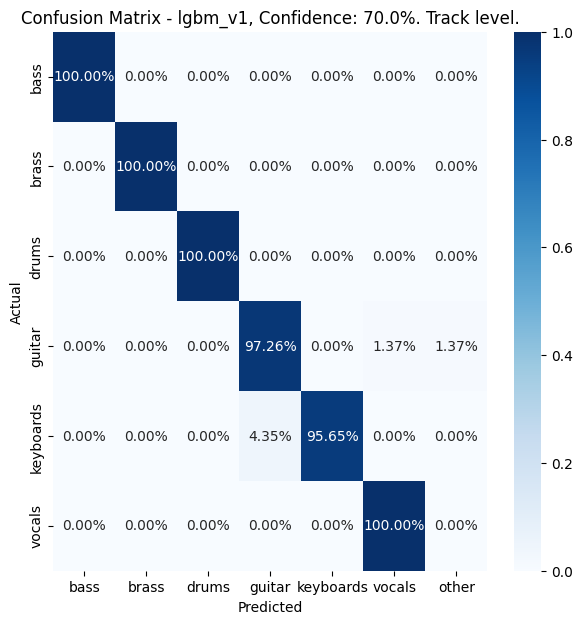

In [63]:
get_confusion_matrix_tracklevel(model_v1, predictions, y_test, validation_features, threshold=threshold)

In [75]:
aux_dataset = validation_features[['track_id']].copy()
aux_dataset['truth'] = y_test
aux_dataset['prediction'] = predictions

In [76]:
class_by_tracks = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'prediction': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

In [78]:
class_by_tracks[class_by_tracks['prediction'] != class_by_tracks['truth']].to_csv('wrong_predictions_v1.csv', index=False)

## Model V2

In [64]:
best_params = {
    "objective": "multiclass",
    "boosting": "gbdt",
    # "num_iterations": 2000,
    "n_estimators": 221,
    "num_leaves": 40,
    "min_child_samples": 6,
    "learning_rate": 0.2250398048171432,
    "log_max_bin": 9,
    "colsample_bytree": 0.6239201684142329,
    "reg_alpha": 0.0009765625,
    "reg_lambda": 0.48807077683502575,
    "is_unbalance": True,
    "max_depth": -1,
}

In [80]:
model_v2 = LightGBMClassifier()
model_v2.fit(X_train, y_train)
model_v2.set_name('LightGBM V2')
predictions_v2 = model_v2.predict(X_test, threshold=threshold)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 15541, number of used features: 253
[LightGBM] [Info] Start training from score -1.527383
[LightGBM] [Info] Start training from score -3.440637
[LightGBM] [Info] Start training from score -1.591013
[LightGBM] [Info] Start training from score -1.388162
[LightGBM] [Info] Start training from score -1.880170
[LightGBM] [Info] Start training from score -1.930775


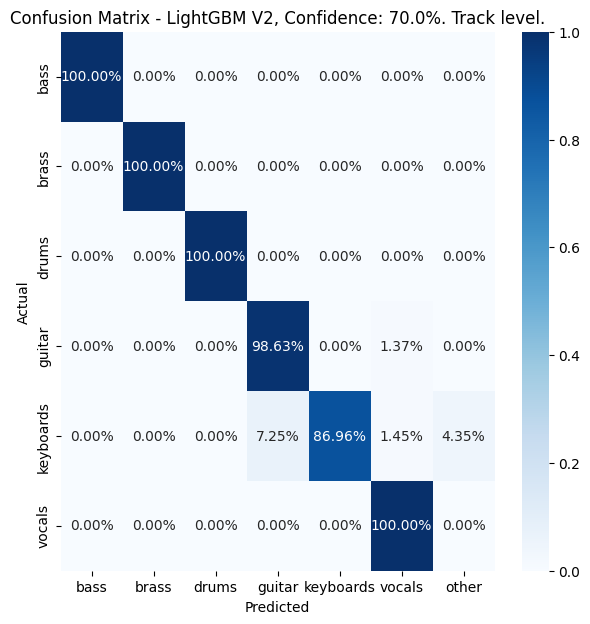

In [67]:
get_confusion_matrix_tracklevel(model_v2, model_v2.predict(X_test, threshold=threshold), y_test, validation_features,threshold=threshold)

In [81]:
aux_dataset['predictions_v2'] = predictions_v2

In [84]:
class_by_tracks = aux_dataset.groupby(['track_id']).agg({
    'truth': 'min',
    'predictions_v2': lambda x: np.random.choice(x.mode(dropna=False))
}).reset_index()

In [85]:
class_by_tracks[class_by_tracks['predictions_v2'] != class_by_tracks['truth']].to_csv('wrong_predictions_v2.csv', index=False)

## Model V2 Fine tuned

In [68]:
model_fine = LightGBMClassifier(**best_params)
model_fine.fit(X_train, y_train)
model_fine.set_name('LightGBM V2 Tuned')

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 15541, number of used features: 253
[LightGBM] [Info] Start training from score -1.527383
[LightGBM] [Info] Start training from score -3.440637
[LightGBM] [Info] Start training from score -1.591013
[LightGBM] [Info] Start training from score -1.388162
[LightGBM] [Info] Start training from score -1.880170
[LightGBM] [Info] Start training from score -1.930775
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


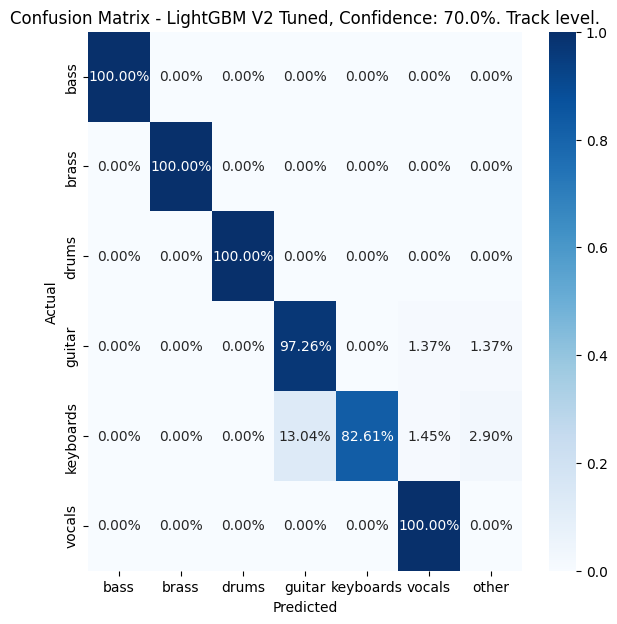

In [70]:
get_confusion_matrix_tracklevel(model_fine, model_fine.predict(X_test, threshold=threshold), y_test, validation_features, threshold=threshold)

## Model V2 Unique

In [71]:
model_unique = LightGBMClassifier()
model_unique.fit(X_train_v2, y_train_v2)
model_unique.set_name('LightGBM V2 Unique data')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64515
[LightGBM] [Info] Number of data points in the train set: 6086, number of used features: 253
[LightGBM] [Info] Start training from score -1.523824
[LightGBM] [Info] Start training from score -3.657501
[LightGBM] [Info] Start training from score -1.611247
[LightGBM] [Info] Start training from score -1.271840
[LightGBM] [Info] Start training from score -2.193125
[LightGBM] [Info] Start training from score -1.802996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

## Model V2 unique data on 

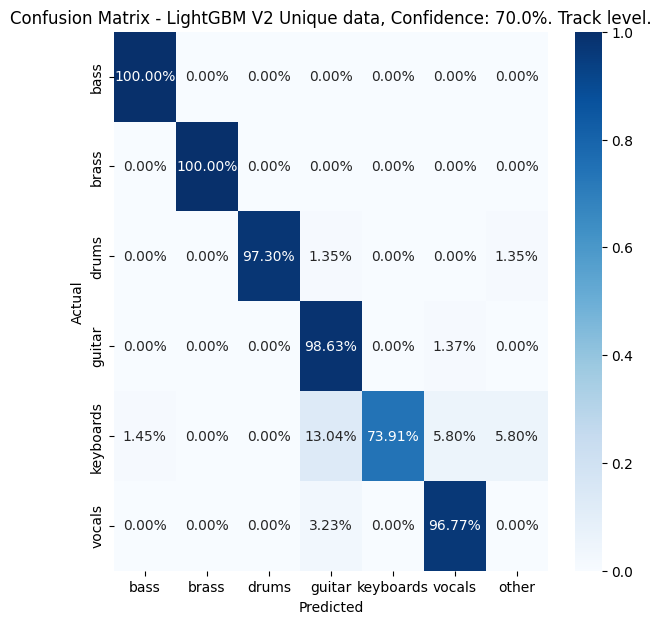

In [73]:
get_confusion_matrix_tracklevel(model_unique, model_unique.predict(X_test, threshold=threshold), y_test, validation_features, threshold=threshold)

## Model V1 on V2 data

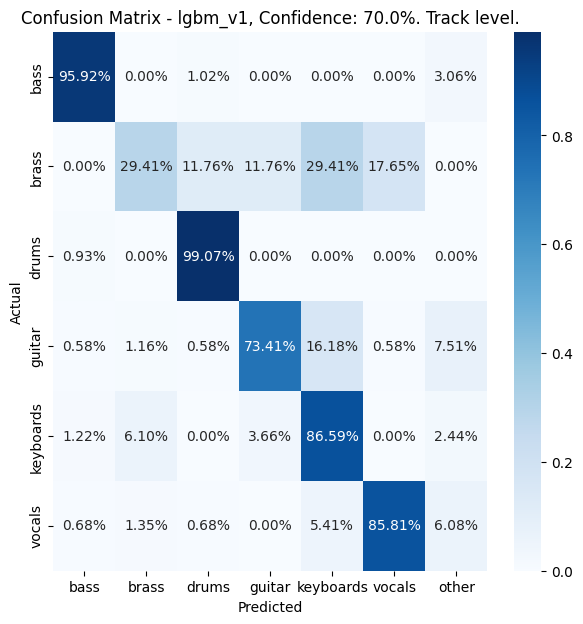

In [74]:
get_confusion_matrix_tracklevel(model_v1, model_v1.predict(X_train_v2, threshold=threshold), y_train_v2, features_v2_unique, threshold=threshold)